## Import modules

In [6]:
import math
# import operator
import sys
import time
# from collections import OrderedDict
# from functools import reduce
import json

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import uproot
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# from skhep.visual import MplPlotter as skh_plt

import multiprocessing
import concurrent.futures

from XRootD import client
from XRootD.client.flags import DirListFlags, StatInfoFlags, OpenFlags, MkDirFlags, QueryCode
# import xrdfs_find

Import local classes from utils

In [7]:
%load_ext jupyternotify
%autonotify -a 10

%load_ext autoreload
%autoreload 1
%aimport utils.ObjectExtractor
%aimport utils.PlotMaker
%aimport utils.HistogramContainer
%aimport utils.HistogramCalculator
OE = utils.ObjectExtractor
PM = utils.PlotMaker
HCont = utils.HistogramContainer
HCalc = utils.HistogramCalculator

<IPython.core.display.Javascript object>

## Global initialization

In [8]:
print(sys.version_info)
# num_cores = multiprocessing.cpu_count()
# print(num_cores)

executor = concurrent.futures.ThreadPoolExecutor(48)

plt.style.use('default')
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams.update({'font.size': 10})

numCuts = np.arange(0,6)

branch_path = 'SREffi_gbm'

sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)


In [9]:
all_plot_vars = ['metpt', 'jetpt','metjetphi', 'metmuphi', 'leadingmupt', 'subleadingmupt', 'recodr', 'recovertex']
plot_vars_metjet = all_plot_vars[0:4] #['metpt', 'jetpt', 'metjetphi', 'metmuphi']
plot_vars_muons = all_plot_vars[4:8] #['leadingmupt', 'subleadingmupt', 'recodr', 'recovertex']
cutflow_vars = ['cutflow_incl', 'cutflow_excl']
all_plot_xlabels = [
    'MET [GeV]', 'Leading jet pT [GeV]', '$\Delta\Phi$(MET, jet)', '$\Delta\Phi$(MET, di-muon)',
    'Leading muon pT [GeV]', 'Subleading muon pT [GeV]', 'dR(muons)', 'Di-muon vertex [cm]']

In [10]:
histos = {}
all_bins = {}
for plot_var in all_plot_vars:
    histos[plot_var] = {}
    all_bins[plot_var] = 60
histos['cutflow_incl'] = {}
histos['cutflow_excl'] = {}
histos['sumgenwgt'] = {}

## Process backgrounds

In [11]:
with open('config/bkgs.json') as bkgs_json_file:
    bkgs = json.load(bkgs_json_file)

In [12]:
QCD_bkgs = {bkg:bkgs[bkg] for bkg in bkgs if 'QCD' in bkg}

In [13]:
xrdfs = client.FileSystem("root://cmseos.fnal.gov/")

# redirector = 'root://cmsxrootd.fnal.gov'
redirector = 'root://cmseos.fnal.gov'
bkg_base_dir = '/store/group/lpcmetx/iDM/Ntuples/2018/backgrounds'
files = {}

for bkg, properties in QCD_bkgs.items():
    files[bkg] = []
    status, listing = xrdfs.dirlist(f'{bkg_base_dir}/{properties["dir"]}', DirListFlags.STAT)
    for file in listing:
        if '.root' in file.name:
            files[bkg].append(f'{redirector}/{bkg_base_dir}/{properties["dir"]}/{file.name}')

In [14]:
num_files_total = np.sum(np.array([len(files[i]) for i in files]))
print(num_files_total)
[(i, len(files[i])) for i in files]

196


[('QCD_bEnriched_HT100to200', 82),
 ('QCD_bEnriched_HT200to300', 63),
 ('QCD_bEnriched_HT300to500', 13),
 ('QCD_bEnriched_HT500to700', 24),
 ('QCD_bEnriched_HT700to1000', 11),
 ('QCD_bEnriched_HT1000to1500', 1),
 ('QCD_bEnriched_HT1500to2000', 1),
 ('QCD_bEnriched_HT2000toINF', 1)]

In [15]:
%%time

# MAX_FILES=None # To load all files
MAX_FILES=30 # For testing

### Initialize empty dicts of histograms 
# histos = {}
# all_bins = {}
# for plot_var in all_plot_vars:
#     histos[plot_var] = {}
#     all_bins[plot_var] = 60
# histos['cutflow_incl'] = {}
# histos['cutflow_excl'] = {}
# histos['sumgenwgt'] = {}

global_file_counter = 1

objects = {}

for bkg in QCD_bkgs:
    objects[bkg] = {}
    
    print(f'Processing background {bkg} ({(list(QCD_bkgs.keys())).index(bkg)+1}/{len(QCD_bkgs)})')
    
    ### Initialize histograms as empty HistogramContainers
    for plot_var in all_plot_vars:
        histos[plot_var][bkg] = HCont.HistogramContainer(all_bins[plot_var])
    histos['cutflow_incl'][bkg] = np.zeros(len(numCuts))
    histos['cutflow_excl'][bkg] = np.zeros(len(numCuts))
    histos['sumgenwgt'][bkg] = 0.0
    
    ### Load data
    file_counter = 1
    for file in files[bkg][slice(0,MAX_FILES)]:
        
        if file_counter % 10 == 1:
            print(f'Reading file {file_counter} of {len(files[bkg])},'
                  f' global {global_file_counter} of {num_files_total}'
                  f' ({100*(global_file_counter-1)/num_files_total:.2f}%)')
#             with open('histos_gbm.dat', 'wb') as histos_file:
#                 pickle.dump(histos, histos_file)
        file_counter += 1
        global_file_counter += 1
        
        ### Open ROOT file and get tree
        tree = uproot.open(file)[branch_path + '/cutsTree']
        
        ### Make pandas dataframes and create all objects that will be passed to histo functions
        obj_extractor = OE.ObjectExtractor(tree)
        objects[bkg][file] = obj_extractor.get_all()
            
        ## Add to sum of genwgts
        histos['sumgenwgt'][bkg] += np.sum(objects[bkg][file]['genwgt'])
        
        ### Calculate histograms and cutflows
        histo_maker = HCalc.HistogramCalculator(objects[bkg][file], bkg)
            
        ### Cutflows
        incl, excl = histo_maker.cutflows()
        histos['cutflow_incl'][bkg] += incl
        histos['cutflow_excl'][bkg] += excl
        
        ### Histograms
        for plot_var in all_plot_vars:
            new_hist = eval(f'histo_maker.{plot_var}()')
            histos[plot_var][bkg] += new_hist

Processing background QCD_bEnriched_HT100to200 (1/8)
Reading file 1 of 82, global 1 of 196 (0.00%)
Reading file 11 of 82, global 11 of 196 (5.10%)
Reading file 21 of 82, global 21 of 196 (10.20%)
Processing background QCD_bEnriched_HT200to300 (2/8)
Reading file 1 of 63, global 31 of 196 (15.31%)
Reading file 11 of 63, global 41 of 196 (20.41%)
Reading file 21 of 63, global 51 of 196 (25.51%)
Processing background QCD_bEnriched_HT300to500 (3/8)
Reading file 1 of 13, global 61 of 196 (30.61%)
Reading file 11 of 13, global 71 of 196 (35.71%)
Processing background QCD_bEnriched_HT500to700 (4/8)
Reading file 1 of 24, global 74 of 196 (37.24%)
Reading file 11 of 24, global 84 of 196 (42.35%)
Reading file 21 of 24, global 94 of 196 (47.45%)
Processing background QCD_bEnriched_HT700to1000 (5/8)
Reading file 1 of 11, global 98 of 196 (49.49%)
Reading file 11 of 11, global 108 of 196 (54.59%)
Processing background QCD_bEnriched_HT1000to1500 (6/8)
Reading file 1 of 1, global 109 of 196 (55.10%)
P

<IPython.core.display.Javascript object>

In [16]:
luminosity = 59.97 # 1/fb, 2018
for bkg, properties in QCD_bkgs.items():
    properties['weight'] = luminosity * properties['xsec'] / histos['sumgenwgt'][bkg]

In [17]:
num_cores = multiprocessing.cpu_count()

# Helper functions to calculate average angles
# This takes a few seconds to run, since we
# are using the apply method

def parallelize(data, func):
#     data_split = np.array_split(data, partitions)
    pool = multiprocessing.Pool(int(num_cores/2))
#     data = pd.concat(pool.map(func, data_split))
    data = pd.concat(pool.map(func, [group for name, group in data]))
    pool.close()
    pool.join()
    return data

def calcAvgAngle(group):
    # FIXME need to ensure at least 2 muons (otherwise index -1 == 0)
    x = np.cos(group['recoPhi'].iloc[0]) + np.cos(group['recoPhi'].iloc[-1])
    y = np.sin(group['recoPhi'].iloc[0]) + np.sin(group['recoPhi'].iloc[-1])
    return math.atan2(y/2, x/2)

def func_group_apply(df):
    # Applies above function on event-by-event basis
    return df.groupby('entry').apply(calcAvgAngle)

def reducephi(row):
    # Helper function to normalize angle differences to [-Pi, Pi]
    # cond: if abs(phidiff) > Pi => phidiff = phidiff - 2*Pi*sign(phidiff)
    if abs(row) > math.pi:
        return row - 2*math.pi*(row/abs(row))
    return row

In [136]:
def compute_hist2d(df, var1, var2, cut=0, **kwargs):
        # Given a dataframe for some observable, adds the
        # gen weight and computes the histogram for it
        if 'bins' not in kwargs:
            kwargs['bins'] = 30

#         temp_df = pd.concat([variables_df, self.genwgt], axis=1).dropna()
        df['genwgt_sqrd'] = df['genwgt']**2
        counts = {}; edges_x = {}; edges_y = {}; wgt_sqrd = {}
#         for cut in numCuts:
#             cuts_to_apply = slice(None) if self.cuts_crit is None else reduce(operator.and_, self.cuts_crit[0:cut+1])
        kwargs['weights'] = df['genwgt']
        counts[cut], edges_x[cut], edges_y[cut] = np.histogram2d(df[var1], df[var2], **kwargs)
            # Digitizes data to find out which bin of histogram each row falls in
        bin_idxs_x = np.digitize(df[var1], edges_x[cut])
        bin_idxs_y = np.digitize(df[var2], edges_y[cut])
#             bin_idxs = np.digitize(temp_df[cuts_to_apply][variable_df.name], edges[cut])
        df['bin_idx_x'] = pd.Series(bin_idxs_x)
        df['bin_idx_y'] = pd.Series(bin_idxs_y)
            # Uses indexes from above to sum the gen weights squared (for errors)
        wgt_sqrd[cut] = df.groupby(['bin_idx_x', 'bin_idx_y']).sum()['genwgt_sqrd']
        return list(zip(counts.values(), edges_x.values(), edges_y.values(), wgt_sqrd.values()))

In [22]:
def compute_hist2d(variables_df, var_name1, var_name2, **kwargs):
        # Given a dataframe for some observable, adds the
        # gen weight and computes the histogram for it
        if 'bins' not in kwargs:
            kwargs['bins'] = 30
#             kwargs['range'] = ((0,6), (0, 20))
#             kwargs['range'] = ((-math.pi,math.pi), (0,6))

#         temp_df = pd.concat([variables_df, self.genwgt], axis=1).dropna()
#         temp_df['genwgt_sqrd'] = temp_df['genwgt']**2
        counts = {}; edges_x = {}; edges_y = {}; wgt_sqrd = {}
        for cut in numCuts:
#             cuts_to_apply = slice(None) if self.cuts_crit is None else reduce(operator.and_, self.cuts_crit[0:cut+1])
            kwargs['weights'] = variables_df['genwgt']
            counts[cut], edges_x[cut], edges_y[cut] = np.histogram2d(variables_df[var_name1], variables_df[var_name2], **kwargs)
            # Digitizes data to find out which bin of histogram each row falls in
#             bin_idxs = np.digitize(temp_df[cuts_to_apply][variable_df.name], edges[cut])
#             temp_df['bin_idx'] = pd.Series(bin_idxs)
            # Uses indexes from above to sum the gen weights squared (for errors)
#             wgt_sqrd[cut] = np.sum(temp_df.groupby('bin_idx'))['genwgt_sqrd']
        return list(zip(counts.values(), edges_x.values(), edges_y.values()))#, wgt_sqrd.values()))

In [23]:
def plot_binned_data_2d(axis, bin_edges_x, bin_edges_y, data, *args, **kwargs):
    #The dataset values are the bin centres
    x = (bin_edges_x[1:] + bin_edges_x[:-1]) / 2.0
    y = (bin_edges_y[1:] + bin_edges_y[:-1]) / 2.0
    X, Y = np.meshgrid(x, y)
    #The weights are the y-values of the input binned data
    weights = data.flatten()
    return axis.hist2d(x=X.flatten(), y=Y.flatten(), bins=[bin_edges_x,bin_edges_y], weights=weights, *args, **kwargs) 

In [ ]:
def calc_ratio_slices(data, slices, ratio_divisor, orientation):
    if orientation == 'horizontal':
        x_slice_bins = np.digitize(slices, data[2])
        y_ratio_div_bin = np.digitize(ratio_divisor, data[1])
        
        integrals_low = [np.sum(np.diff(data[2][x_slice_bin-1:x_slice_bin+1])*
                                np.diff(data[1][0:y_ratio_div_bin+1])*
                                data[0][x_slice_bin][0:y_ratio_div_bin]) for x_slice_bin in x_slice_bins]
        
        errors_low = [np.sum(np.diff(data[2][x_slice_bin-1:x_slice_bin+1])*
                             np.diff(data[1][0:y_ratio_div_bin+1])*
                             np.sqrt(data[3][x_slice_bin][0:y_ratio_div_bin])) for x_slice_bin in x_slice_bins]
        
        integrals_high = [np.sum(np.diff(data[2][x_slice_bin-1:x_slice_bin+1])*
                                 np.diff(data[1][y_ratio_div_bin:])*
                                 data[0][x_slice_bin][y_ratio_div_bin:]) for x_slice_bin in x_slice_bins]
        
        errors_high = [np.sum(np.diff(data[2][x_slice_bin-1:x_slice_bin+1])*
                              np.diff(data[1][y_ratio_div_bin:])*
                              np.sqrt(data[3][x_slice_bin][y_ratio_div_bin:])) for x_slice_bin in x_slice_bins]
        
    elif orientation == 'vertical':
        y_slice_bins = np.digitize(slices, data[1])
        x_ratio_div_bin = np.digitize(ratio_divisor, data[2])
        
        integrals_low = [np.sum(np.diff(data[2][0:x_ratio_div_bin+1])*
                                np.diff(data[1][y_slice_bin-1:y_slice_bin+1])*
                                data[0][0:x_ratio_div_bin,y_slice_bin]) for y_slice_bin in y_slice_bins]
        
        errors_low = [np.sum(np.diff(data[2][0:x_ratio_div_bin+1])*
                             np.diff(data[1][y_slice_bin-1:y_slice_bin+1])*
                             np.sqrt(data[3].loc[1:x_ratio_div_bin, y_slice_bin])) for y_slice_bin in y_slice_bins]
        
        integrals_high = [np.sum(np.diff(data[2][x_ratio_div_bin:])*
                                 np.diff(data[1][y_slice_bin-1:y_slice_bin+1])*
                                 data[0][x_ratio_div_bin:,y_slice_bin]) for y_slice_bin in y_slice_bins]
        
        errors_high = [np.sum(np.diff(data[2][x_ratio_div_bin:])*
                              np.diff(data[1][y_slice_bin-1:y_slice_bin+1])*
                              np.sqrt(data[3].loc[x_ratio_div_bin+1:30,y_slice_bin])) for y_slice_bin in y_slice_bins]
        
    if np.sum(integrals_low) > np.sum(integrals_high):
        ratio = np.divide(integrals_high, integrals_low)
    else:
        ratio = np.divide(integrals_low, integrals_high)
        
    error_ratio = ratio * (np.divide(errors_high,integrals_high) + np.divide(errors_low, integrals_low))
    
    return (ratio, error_ratio)

Text(0,0.5,'|$\\Delta\\Phi$(MET, muons)|')

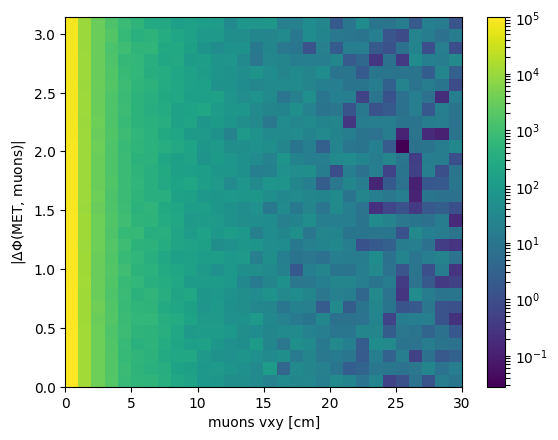

<IPython.core.display.Javascript object>

In [491]:
total_hist = None
total_df = pd.DataFrame()

for bkg in objects:
    for file, obj in objects[bkg].items():

        muons = obj['muons'].reset_index()
        muons['data_chunk'] = muons['entry'].mod(int(num_cores * 3 / 2)) # num_cores/2 * 3 chunks/core
        muons = muons.set_index(['entry'])
        # Here, group by data_chunk instead of entry, inside func_group_apply
        # we also have a groupby('entry')
        avg_muon_angle = parallelize(muons.groupby('data_chunk'), func_group_apply)
        angle_diff = (obj['MET']['recoPFMetPhi'].dropna() - avg_muon_angle).dropna()
        reduced_angle_diff = np.abs(angle_diff.apply(reducephi).dropna())
        reduced_angle_diff.name = 'reducedAngleDiff'

        df = pd.concat([reduced_angle_diff, obj['vertex']['recoVxy'], obj['genwgt']*QCD_bkgs[bkg]['weight']], axis=1).dropna()
        total_df = pd.concat([total_df, df], ignore_index=True)
        current_hist = compute_hist2d(df, 'reducedAngleDiff', 'recoVxy', cut=0, range=((0,math.pi),(0,30)));
        if total_hist is None:
            total_hist = current_hist[0][0]
            total_wgt_sqrd = current_hist[0][3]
        else:
            total_hist += current_hist[0][0]
            total_wgt_sqrd = total_wgt_sqrd.add(current_hist[0][3], fill_value=0)

total_wgt_sqrd = total_wgt_sqrd.reindex(pd.MultiIndex.from_product([np.arange(1,31), np.arange(1,31)]), fill_value=0)
            
plot_binned_data_2d(plt, current_hist[0][2], current_hist[0][1], total_hist, norm=mpl.colors.LogNorm());
plt.colorbar()
plt.xlabel('muons vxy [cm]')
plt.ylabel(r'|$\Delta\Phi$(MET, muons)|')

Text(0,0.5,'ratio low/high')

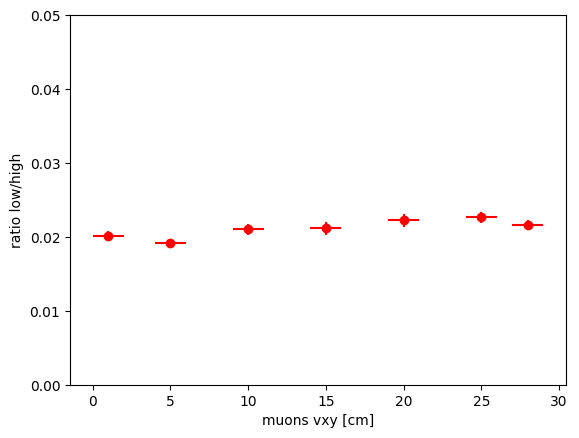

In [492]:
XSliceVals = [1,5,10,15,20,25,28]
YDivVal = 0.5
ratio, err = calc_ratio_slices([total_hist, current_hist[0][1], current_hist[0][2], total_wgt_sqrd], XSliceVals, YDivVal, 'horizontal')

plt.errorbar(XSliceVals, ratio, xerr=[np.diff(current_hist[0][2][0:2])]*len(ratio), yerr=err, fmt='ro')
plt.ylim([0.0,.05])
plt.xlabel("muons vxy [cm]")
plt.ylabel("ratio low/high")

Text(0,0.5,'ratio low/high')

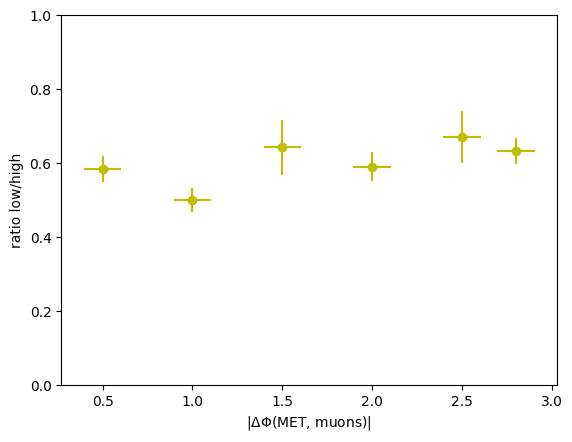

In [493]:
YSliceVals = [0.5,1.0,1.5,2.0,2.5,2.8]
XDivVal = 10
ratio, err = calc_ratio_slices([total_hist, current_hist[0][1], current_hist[0][2], total_wgt_sqrd], YSliceVals, XDivVal, 'vertical')

plt.errorbar(YSliceVals, ratio, xerr=[np.diff(current_hist[0][1][0:2])]*len(ratio), yerr=err, fmt='yo')
plt.ylim([0.0,1.0])
plt.xlabel(r'|$\Delta\Phi$(MET, muons)|')
plt.ylabel("ratio low/high")

In [84]:
total_df[['reducedAngleDiff','recoVxy']].corr()

,reducedAngleDiff,recoVxy
reducedAngleDiff,1.000000,-0.005956
recoVxy,-0.005956,1.000000


Text(0,0.5,'|$\\Delta\\Phi$(MET, muons)|')

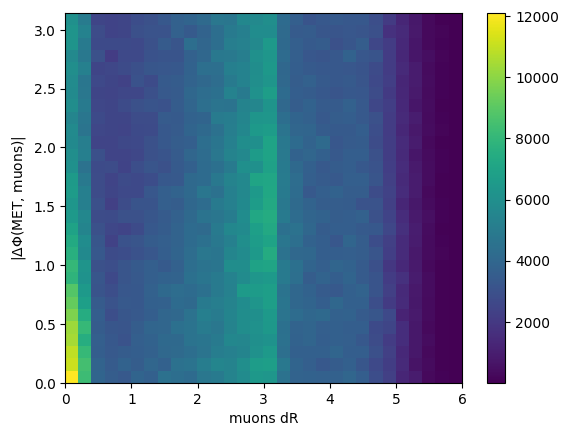

<IPython.core.display.Javascript object>

In [397]:
total_hist = None

for bkg in objects:
    for file, obj in objects[bkg].items():

        muons = obj['muons'].reset_index()
        muons['data_chunk'] = muons['entry'].mod(int(num_cores * 3 / 2)) # num_cores/2 * 3 chunks/core
        muons = muons.set_index(['entry'])
        # Here, group by data_chunk instead of entry, inside func_group_apply
        # we also have a groupby('entry')
        avg_muon_angle = parallelize(muons.groupby('data_chunk'), func_group_apply)
        angle_diff = (obj['MET']['recoPFMetPhi'].dropna() - avg_muon_angle).dropna()
        reduced_angle_diff = np.abs(angle_diff.apply(reducephi).dropna())
        reduced_angle_diff.name = 'reducedAngleDiff'

        df = pd.concat([reduced_angle_diff, obj['vertex']['recoDr'], obj['genwgt']*QCD_bkgs[bkg]['weight']], axis=1).dropna()
        current_hist = compute_hist2d(df, 'reducedAngleDiff', 'recoDr', cut=0, range=((0,math.pi),(0,6)));
        if total_hist is None:
            total_hist = current_hist[0][0]
            total_wgt_sqrd = current_hist[0][3]
        else:
            total_hist += current_hist[0][0]
            total_wgt_sqrd = total_wgt_sqrd.add(current_hist[0][3], fill_value=0)

total_wgt_sqrd = total_wgt_sqrd.reindex(pd.MultiIndex.from_product([np.arange(1,31), np.arange(1,31)]), fill_value=0)
    
plot_binned_data_2d(plt, current_hist[0][2], current_hist[0][1], total_hist)#, norm=mpl.colors.LogNorm());
plt.colorbar()
plt.xlabel('muons dR')
plt.ylabel(r'|$\Delta\Phi$(MET, muons)|')

Text(0,0.5,'ratio low/high')

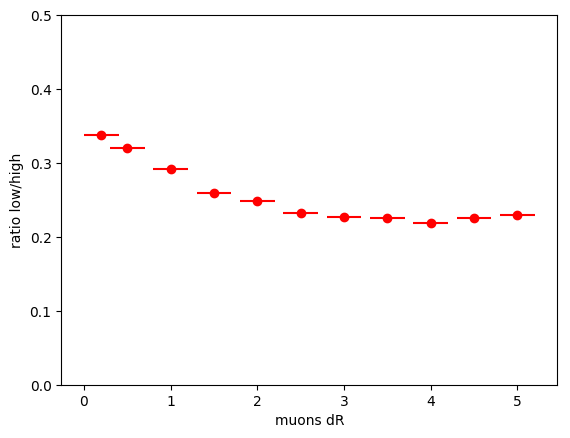

In [437]:
XSliceVals = [0.2,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]
YDivVal = 0.5
ratio, err = calc_ratio_slices([total_hist, current_hist[0][1], current_hist[0][2], total_wgt_sqrd], XSliceVals, YDivVal, 'horizontal')

plt.errorbar(XSliceVals, ratio, xerr=[np.diff(current_hist[0][2][0:2])]*len(ratio), yerr=err, fmt='ro')
plt.ylim([0.0,.5])
plt.xlabel("muons dR")
plt.ylabel("ratio low/high")

Text(0,0.5,'ratio low/high')

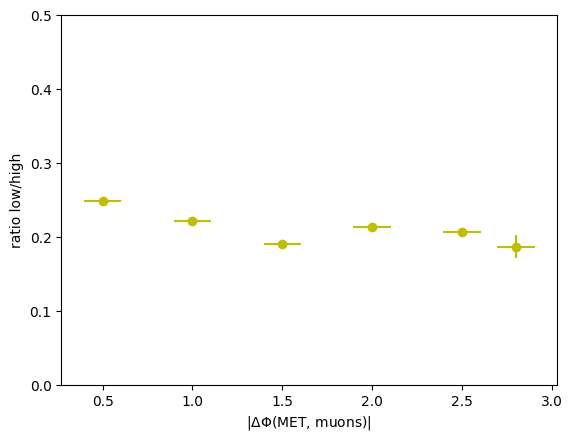

In [453]:
YSliceVals = [0.5,1.0,1.5,2.0,2.5,2.8]
XDivVal = 0.8
ratio, err = calc_ratio_slices([total_hist, current_hist[0][1], current_hist[0][2], total_wgt_sqrd], YSliceVals, XDivVal, 'vertical')

plt.errorbar(YSliceVals, ratio, xerr=[np.diff(current_hist[0][1][0:2])]*len(ratio), yerr=err, fmt='yo')
plt.ylim([0.0,.5])
plt.xlabel(r'|$\Delta\Phi$(MET, muons)|')
plt.ylabel("ratio low/high")

In [117]:
np.corrcoef(df['recoDr'], df['reducedAngleDiff'], rowvar=False)

array([[1.        , 0.21447854],
       [0.21447854, 1.        ]])

Text(0,0.5,'muons dR')

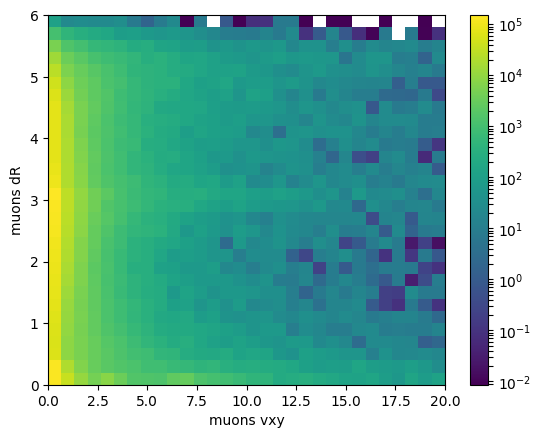

<IPython.core.display.Javascript object>

In [454]:
total_hist = None

for bkg in objects:
    for file, obj in objects[bkg].items():

        df = pd.concat([obj['vertex']['recoDr'], obj['vertex']['recoVxy'], obj['genwgt']*QCD_bkgs[bkg]['weight']], axis=1).dropna()
        current_hist = compute_hist2d(df, 'recoDr', 'recoVxy', cut=0, range=((0,6),(0,20)));
        if total_hist is None:
            total_hist = current_hist[0][0]
            total_wgt_sqrd = current_hist[0][3]
        else:
            total_hist += current_hist[0][0]
            total_wgt_sqrd = total_wgt_sqrd.add(current_hist[0][3], fill_value=0)
            
total_wgt_sqrd = total_wgt_sqrd.reindex(pd.MultiIndex.from_product([np.arange(1,31), np.arange(1,31)]), fill_value=0)
    
plot_binned_data_2d(plt, current_hist[0][2], current_hist[0][1], total_hist, norm=mpl.colors.LogNorm());
plt.colorbar()
plt.xlabel('muons vxy')
plt.ylabel('muons dR')

Text(0,0.5,'ratio low/high')

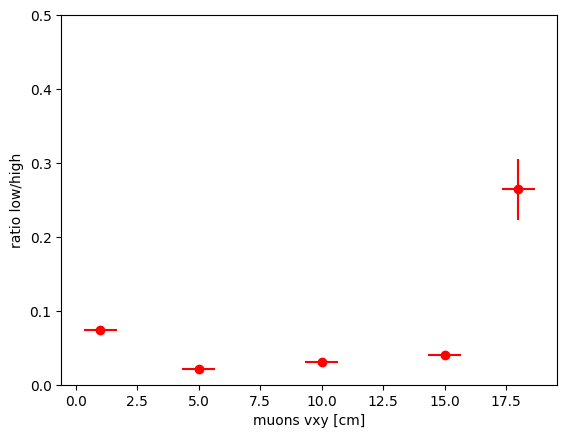

In [489]:
XSliceVals = [1,5,10,15,18]
YDivVal = 0.8
ratio, err = calc_ratio_slices([total_hist, current_hist[0][1], current_hist[0][2], total_wgt_sqrd], XSliceVals, YDivVal, 'horizontal')

plt.errorbar(XSliceVals, ratio, xerr=[np.diff(current_hist[0][2][0:2])]*len(ratio), yerr=err, fmt='ro')
plt.ylim([0.0,.5])
plt.xlabel("muons vxy [cm]")
plt.ylabel("ratio low/high")

Text(0,0.5,'ratio low/high')

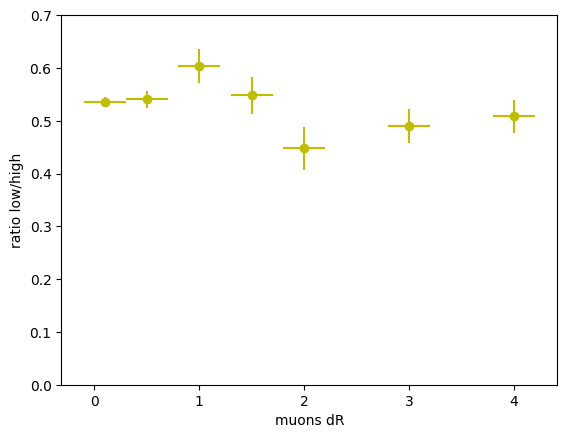

In [490]:
YSliceVals = [0.1,0.5,1.0,1.5,2.0,3.0,4.0]
XDivVal = 10
ratio, err = calc_ratio_slices([total_hist, current_hist[0][1], current_hist[0][2], total_wgt_sqrd], YSliceVals, XDivVal, 'vertical')

plt.errorbar(YSliceVals, ratio, xerr=[np.diff(current_hist[0][1][0:2])]*len(ratio), yerr=err, fmt='yo')
plt.ylim([0.0,.7])
plt.xlabel("muons dR")
plt.ylabel("ratio low/high")

In [157]:
total_recoDr = pd.Series()
for bkg in QCD_bkgs:
    for obj in objects[bkg].values():
        total_recoDr = pd.concat([total_recoDr, obj['vertex'][['recoDr','recoVxy']]],ignore_index=True)

In [159]:
total_recoDr.corr()

,0,recoDr,recoVxy
0,NaN,NaN,NaN
recoDr,NaN,1.000000,-0.045377
recoVxy,NaN,-0.045377,1.000000
